In [2]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
from shapely import wkt
import contextily as cx
import pyproj
from pyproj import Transformer
from shapely.ops import transform
import matplotlib.pyplot as plt
import mapclassify
import numpy as np

### Occupations

In [3]:
# categories for the areas of work
orig_street_names = pd.read_excel('Work and Years.xlsx')

In [4]:
street_names = pd.read_excel('Work and Years.xlsx')

In [5]:
street_names.head()

,Unnamed: 0,osm_id,code,fclass,name,type,work,born-died,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,2,3192369,5122,residential,Rruga Brigada VIII,O,NaN,NaN,NaN,F,20,0,F,F,"LINESTRING (19.817793 41.3223873, 19.8177494 4..."
1,3,3192381,5122,residential,Rruga Emin Duraku,M,Partisan,1918-1942,NaN,F,30,0,F,F,"LINESTRING (19.8086264 41.3196481, 19.8087541 ..."
2,4,3192411,5122,residential,NaN,NaN,NaN,NaN,NaN,F,0,0,F,F,"LINESTRING (19.8156603 41.3195312, 19.8157016 ..."
3,5,3192422,5122,residential,Rruga Vaso Pasha,M,Writer,1825-1892,NaN,F,30,0,F,F,"LINESTRING (19.8154385 41.3228944, 19.8154526 ..."
4,6,3192445,5123,living_street,Rruga Mihal Popi,M,Actor,1909-1979,NaN,F,0,0,F,F,"LINESTRING (19.8069018 41.3200073, 19.8067189 ..."


In [6]:
street_names = street_names.drop_duplicates('name')

In [7]:
len(street_names['name'].unique())

643

In [8]:
grouped_work = street_names.groupby(['name', 'work'], as_index = False).count().groupby('work', as_index = False).count().sort_values('name', ascending = False)

In [9]:
grouped_work.head(10)

,work,name,Unnamed: 0,osm_id,code,fclass,type,born-died,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
48,Politician,48,48,48,48,48,48,48,48,48,48,48,48,48,48
61,Writer,38,38,38,38,38,38,38,38,38,38,38,38,38,38
23,Fighter,25,25,25,25,25,25,25,25,25,25,25,25,25,25
43,Partisan,22,22,22,22,22,22,22,22,22,22,22,22,22,22
49,Religious,14,14,14,14,14,14,14,14,14,14,14,14,14,14
42,Painter,9,9,9,9,9,9,9,9,9,9,9,9,9,9
12,Composer,8,8,8,8,8,8,8,8,8,8,8,8,8,8
56,Singer,8,8,8,8,8,8,8,8,8,8,8,8,8,8
52,Researcher,8,8,8,8,8,8,8,8,8,8,8,8,8,8
15,Doctor,8,8,8,8,8,8,8,8,8,8,8,8,8,8


In [10]:
len(grouped_work['work'])

62

In [11]:
(22)/grouped_work['Unnamed: 0'].sum()

0.08

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


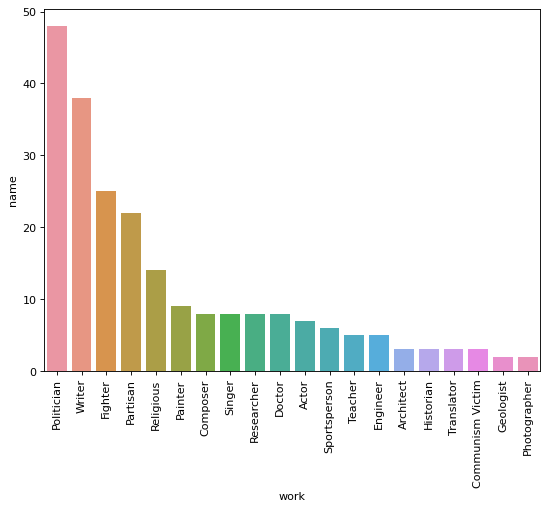

In [12]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

sns.barplot(grouped_work['work'].head(20), grouped_work['name'].head(20));
plt.xticks(rotation = 90);

In [13]:
# a bunch of politicians, which years?

In [14]:
politicians = street_names[street_names['work'] == 'Politician'].drop_duplicates(subset = 'name')

In [15]:
politicians['birthyear'] = politicians['born-died'].str.split('-').str[0]
politicians['deathyear'] = politicians['born-died'].str.split('-').str[1]

In [16]:
np.mean(politicians['birthyear'].astype(float))

1882.675

In [17]:
np.mean(politicians[politicians['deathyear'] != '']['deathyear'].astype(float))

1936.0

In [18]:
# earliest/most recent politician

In [19]:
np.min(politicians['birthyear'].astype(float))

1809.0

In [20]:
politicians[politicians['birthyear'] == '1809']

,Unnamed: 0,osm_id,code,fclass,name,type,work,born-died,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,birthyear,deathyear
2358,10784,173642286,5122,residential,Rruga Abraham Linkoln,M,Politician,1809-1865,NaN,B,0,0,F,F,"LINESTRING (19.8019932 41.3126324, 19.8021738 ...",1809,1865


In [21]:
np.max(politicians['birthyear'].astype(float))

1955.0

In [22]:
politicians[politicians['birthyear'] == '1955']

,Unnamed: 0,osm_id,code,fclass,name,type,work,born-died,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,birthyear,deathyear
624,1427,45565664,5122,residential,Rruga Nikolas Sarkozi,M,Politician,1955-,NaN,B,0,0,F,F,"LINESTRING (19.7530263 41.3742894, 19.7542456 ...",1955,


In [23]:
# distribution of birth and death years

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


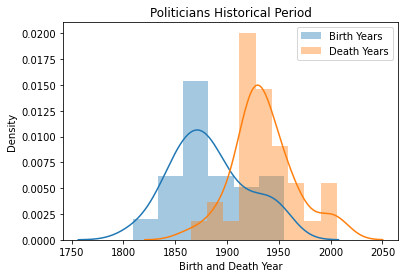

In [42]:
sns.distplot(politicians['birthyear'], label ='Birth Years');
sns.distplot(politicians[politicians['deathyear'] != '']['deathyear'], label ='Death Years');
plt.xlabel("Birth and Death Year");
plt.legend();
plt.title("Politicians Historical Period");

In [37]:
# writers?

In [43]:
writers = street_names[street_names['work'] == 'Writer'].drop_duplicates(subset = 'name')
writers['birthyear'] = writers['born-died'].str.split('-').str[0]
writers['deathyear'] = writers['born-died'].str.split('-').str[1]
np.mean(writers['birthyear'].astype(float))

1858.1842105263158

In [44]:
np.mean(writers['deathyear'].astype(float))

1925.7368421052631

In [45]:
# distribution

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


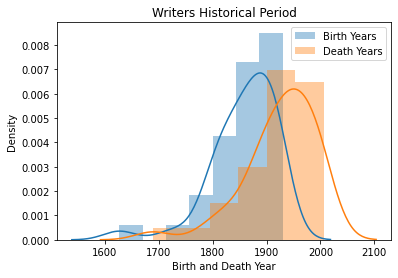

In [46]:
sns.distplot(writers['birthyear'], label ='Birth Years');
sns.distplot(writers[writers['deathyear'] != '']['deathyear'], label ='Death Years');

plt.xlabel("Birth and Death Year");
plt.legend();
plt.title("Writers Historical Period");

In [47]:
# fighters

In [48]:
fighters = street_names[street_names['work'] == 'Fighter'].drop_duplicates(subset = 'name')
fighters['birthyear'] = fighters['born-died'].str.split('-').str[0]
fighters['deathyear'] = fighters['born-died'].str.split('-').str[1]

In [49]:
np.mean(fighters['birthyear'].astype(float))

1853.4117647058824

In [50]:
np.mean(fighters[fighters['deathyear'] != '']['deathyear'].astype(float))

1900.0

In [51]:
# distribution

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


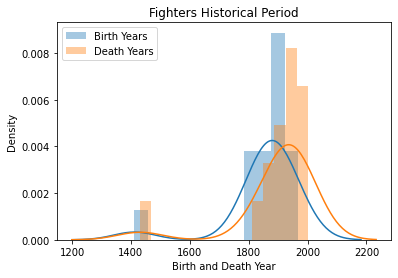

In [52]:
sns.distplot(fighters['birthyear'], label ='Birth Years');
sns.distplot(fighters[fighters['deathyear'] != '']['deathyear'], label ='Death Years');

plt.xlabel("Birth and Death Year");
plt.legend();
plt.title("Fighters Historical Period");

In [53]:
# street classes by work area, most common

In [54]:
street_class = street_names.drop_duplicates(subset = 'name').groupby(['work', 'fclass'], as_index = False).count().sort_values('Unnamed: 0', ascending = False).drop_duplicates('work')

In [55]:
# what about the ones which are not residential?

In [56]:
street_class[street_class['fclass'] != 'residential']

,work,fclass,Unnamed: 0,osm_id,code,name,type,born-died,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
37,Historian,living_street,2,2,2,2,2,2,0,2,2,2,2,2,2
64,Poet,service,1,1,1,1,1,1,0,1,1,1,1,1,1
73,Religous,tertiary,1,1,1,1,1,1,0,1,1,1,1,1,1
46,Media,primary,1,1,1,1,1,1,0,1,1,1,1,1,1
52,Nobleman/Fighter,unclassified,1,1,1,1,1,1,0,1,1,1,1,1,1
17,Dissident Poet,service,1,1,1,1,1,1,0,1,1,1,1,1,1
13,Communist/Politician,primary,1,1,1,1,1,0,0,1,1,1,1,1,1
24,"Engineer, Communist Politician",tertiary,1,1,1,1,1,1,0,1,1,1,1,1,1
6,Astronomer,secondary,1,1,1,1,1,1,0,1,1,1,1,1,1
3,Actress,service,1,1,1,1,1,1,0,1,1,1,1,1,1


In [57]:
# service street: road running parallel to main road
# living street: lower speed lims to residential
# tertiary and secondary streets: roads connecting smaller settlements and local centers

### Other Interesting Stories

### Streets named after women

In [58]:
# women: what years typically

In [59]:
streets_women = street_names.drop_duplicates(subset = 'name')[street_names['type'] == 'F']

In [60]:
streets_women.head()

,Unnamed: 0,osm_id,code,fclass,name,type,work,born-died,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
98,387,30823489,5122,residential,Rruga Vaçe Zela,F,Singer,1939-2014,NaN,F,0,0,F,F,"LINESTRING (19.7940791 41.3240031, 19.7941038 ..."
217,626,41488032,5115,tertiary,Rruga Erisa Fatmir Poleshi,F,Politician,NaN,NaN,F,0,0,F,F,"LINESTRING (19.7876165 41.3519923, 19.7876057 ..."
220,629,41488260,5122,residential,Rruga Rozafa,F,NaN,NaN,NaN,B,0,0,F,F,"LINESTRING (19.7996674 41.3809254, 19.7986638 ..."
376,1179,44960052,5122,residential,Rruga Zana Floqi,F,NaN,NaN,NaN,B,0,0,F,F,"LINESTRING (19.8524275 41.3397825, 19.8523896 ..."
380,1183,44960061,5122,residential,Rruga Shotë Galica,F,Fighter,1895-1927,NaN,B,0,0,F,F,"LINESTRING (19.8610728 41.3380046, 19.8609041 ..."


In [61]:
streets_women['birthyear'] = streets_women['born-died'].str.split('-').str[0]
streets_women['deathyear'] = streets_women['born-died'].str.split('-').str[1]

In [62]:
np.nanmedian(streets_women['birthyear'].astype(float))

1912.0

In [63]:
np.nanmedian(streets_women[streets_women['deathyear'] != '']['deathyear'].astype(float))

1949.0

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


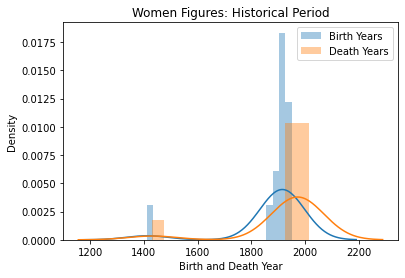

In [65]:
# also distribution
sns.distplot(streets_women['birthyear'], label ='Birth Years');
sns.distplot(streets_women[streets_women['deathyear'] != '']['deathyear'], label ='Death Years');

plt.xlabel("Birth and Death Year");
plt.legend();
plt.title("Women Figures: Historical Period");

### Mapping it out: neighborhoods

In [67]:
street_names['geometry'] = street_names['geometry'].apply(wkt.loads)
street_names_geo = gpd.GeoDataFrame(street_names, geometry = street_names['geometry'], crs="EPSG:4326")

findfont: Font family ['Palatino Linotype'] not found. Falling back to DejaVu Sans.


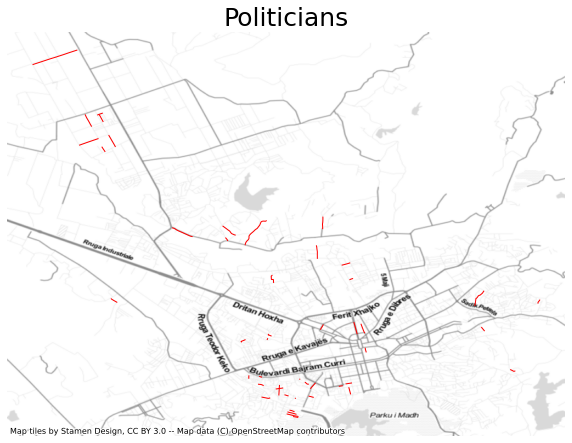

In [68]:
ax = street_names_geo[street_names_geo['work'] == 'Politician'].plot(color="red", figsize=(10, 10), linewidth=1)
ax.axis("off");
plt.title("Politicians", fontsize=25, fontname="Palatino Linotype", color="black");
cx.add_basemap(ax, crs=street_names_geo[street_names_geo['work'] == 'Politician'].crs.to_string(), source=cx.providers.Stamen.TonerLite)

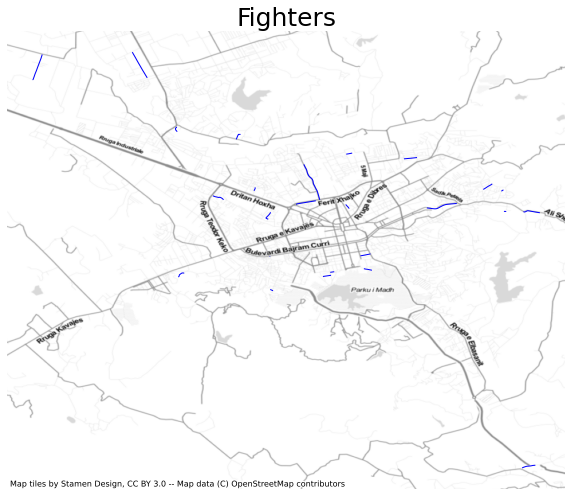

In [69]:
ax2 = street_names_geo[street_names_geo['work'] == 'Fighter'].plot(color="blue", figsize=(10, 10), linewidth=1)
ax2.axis("off");
plt.title("Fighters", fontsize=25, fontname="Palatino Linotype", color="black");
cx.add_basemap(ax2, crs=street_names_geo[street_names_geo['work'] == 'Fighter'].crs.to_string(), source=cx.providers.Stamen.TonerLite)

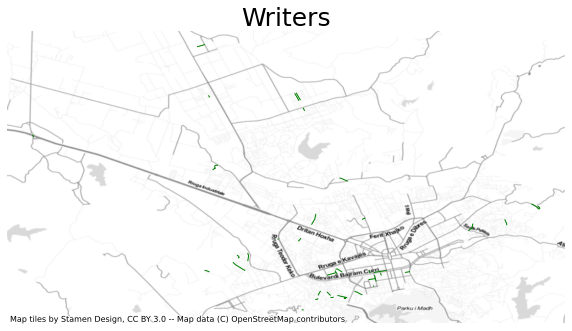

In [71]:
ax2 = street_names_geo[street_names_geo['work'] == 'Writer'].plot(color="green", figsize=(10, 10), linewidth=1)
ax2.axis("off");
plt.title("Writers", fontsize=25, fontname="Palatino Linotype", color="black");
cx.add_basemap(ax2, crs=street_names_geo[street_names_geo['work'] == 'Writer'].crs.to_string(), source=cx.providers.Stamen.TonerLite)

In [114]:
# analyze by administrative area

In [73]:
admin_areas = gpd.read_file('nj_sit__administrative.geojson')

In [74]:
len(gpd.GeoDataFrame(street_names)['name'].unique())

643

In [81]:
# work not null, birthdeath not null
street_names = gpd.GeoDataFrame(street_names)
street_names = street_names[street_names['work'].notna()]

In [82]:
street_neighborhoods = gpd.sjoin(street_names, admin_areas)
street_neighborhoods.loc[street_neighborhoods['nr_njesie'] == '04', 'nr_njesie'] = 4
street_neighborhoods['nr_njesie'] = street_neighborhoods['nr_njesie'].map(lambda x: int(x))
urban_tirana = street_neighborhoods[street_neighborhoods['nr_njesie'] <= 14]

In [83]:
# occupation

In [84]:
grouped_njesi_work = urban_tirana.groupby(['nr_njesie', 'work'], as_index = False).count()

In [85]:
# most common prof in each njesi?

In [88]:
grouped_njesi_work = grouped_njesi_work.sort_values('Unnamed: 0', ascending = False).drop_duplicates('nr_njesie')
grouped_njesi_work.rename(columns = {'Unnamed: 0': 'Counts', "nr_njesie": 'Admin_Area'})

,Admin_Area,work,Counts,osm_id,code,fclass,name_left,type,born-died,ref,...,bridge,tunnel,geometry,index_right,id,emertimi,njesia_adm,name_right,_umap_options,description
61,5,Politician,45,45,45,45,45,45,39,0,...,45,45,45,45,45,45,45,45,45,0
118,9,Politician,18,18,18,18,18,18,15,0,...,18,18,18,18,18,18,18,18,18,0
150,14,Writer,12,12,12,12,12,12,12,0,...,12,12,12,12,12,12,12,12,12,0
149,13,Politician,12,12,12,12,12,12,12,0,...,12,12,12,12,12,12,12,12,12,0
3,1,Fighter,12,12,12,12,12,12,12,0,...,12,12,12,12,12,12,12,12,12,12
89,7,Politician,12,12,12,12,12,12,9,0,...,12,12,12,12,12,12,12,12,12,0
102,8,Partisan,12,12,12,12,12,12,12,0,...,12,12,12,12,12,12,12,12,12,0
17,2,Partisan,9,9,9,9,9,9,9,0,...,9,9,9,9,9,9,9,9,9,0
139,11,Religious,9,9,9,9,9,9,6,0,...,9,9,9,9,9,9,9,9,9,0
126,10,Partisan,6,6,6,6,6,6,6,0,...,6,6,6,6,6,6,6,6,6,0


### Names with no info?

In [89]:
# names with no information online

In [90]:
orig_street_names = orig_street_names.drop_duplicates('name')

In [91]:
orig_street_names

,Unnamed: 0,osm_id,code,fclass,name,type,work,born-died,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,2,3192369,5122,residential,Rruga Brigada VIII,O,NaN,NaN,NaN,F,20,0,F,F,"LINESTRING (19.817793 41.3223873, 19.8177494 4..."
1,3,3192381,5122,residential,Rruga Emin Duraku,M,Partisan,1918-1942,NaN,F,30,0,F,F,"LINESTRING (19.8086264 41.3196481, 19.8087541 ..."
2,4,3192411,5122,residential,NaN,NaN,NaN,NaN,NaN,F,0,0,F,F,"LINESTRING (19.8156603 41.3195312, 19.8157016 ..."
3,5,3192422,5122,residential,Rruga Vaso Pasha,M,Writer,1825-1892,NaN,F,30,0,F,F,"LINESTRING (19.8154385 41.3228944, 19.8154526 ..."
4,6,3192445,5123,living_street,Rruga Mihal Popi,M,Actor,1909-1979,NaN,F,0,0,F,F,"LINESTRING (19.8069018 41.3200073, 19.8067189 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,11112,173998513,5123,living_street,Rruga 23,O,NaN,NaN,NaN,F,0,0,F,F,"LINESTRING (19.8043852 41.3204194, 19.8031513 ..."
2494,11113,173998514,5123,living_street,Rruga 24,O,NaN,NaN,NaN,F,0,0,F,F,"LINESTRING (19.8030744 41.3205073, 19.8043085 ..."
2495,11114,174150359,5122,residential,Rruga Ismail Feta,M,Doctor,NaN,NaN,B,0,0,F,F,"LINESTRING (19.7711402 41.3523566, 19.7712287 ..."
2496,11115,174150360,5115,tertiary,Rruga Imer Ndregjoni,M,NaN,NaN,NaN,B,40,0,F,F,"LINESTRING (19.8384809 41.3448845, 19.8389403 ..."


In [92]:
orig_street_names_na = orig_street_names[orig_street_names['work'].isna()]

In [93]:
orig_street_names_notna = orig_street_names[orig_street_names['work'].notna()]
len(orig_street_names_notna[orig_street_names_notna['type'] != 'O']['name'].unique())

275

In [94]:
# 152 streets named after people with no information online

In [95]:
len(orig_street_names_na[orig_street_names_na['type'] != 'O']['name'].unique())

152

In [96]:
152/276

0.5507246376811594

/var/folders/__/8q6wtgc10gsdhs_z1lv_0r700000gn/T/ipykernel_8653/3539711361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orig_street_names_na['geometry'] = orig_street_names_na['geometry'].apply(wkt.loads)


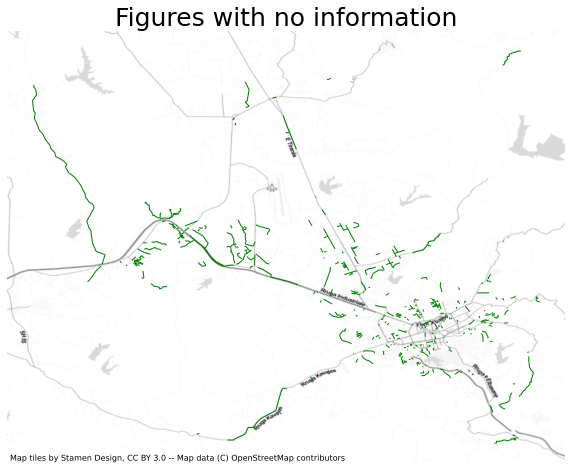

In [98]:
orig_street_names_na['geometry'] = orig_street_names_na['geometry'].apply(wkt.loads)
orig_street_names_na = gpd.GeoDataFrame(orig_street_names_na, geometry = orig_street_names_na['geometry'], crs="EPSG:4326")
ax2 = orig_street_names_na.plot(color="green", figsize=(10, 10), linewidth=1)
ax2.axis("off");
plt.title("Figures with no information", fontsize=25, fontname="Palatino Linotype", color="black");
cx.add_basemap(ax2, crs=orig_street_names_na.crs.to_string(), source=cx.providers.Stamen.TonerLite)